This is the documentation for "M1M2: Deep-Learning-Based Real-Time Emotion Recognition from Neural Activity" paper by

Sumya Akter 1†, Rumman Ahmed Prodhan 1†, Tanmoy Sarkar Pias 2* , David Eisenberg 3*
and Jorge Fresneda Fernandez 1

1.   Martin Tuchman School of Management, New Jersey Institute of Technology, Newark, NJ 07102, USA 
2.   Department of Computer Science, Virginia Tech, Blacksburg, VA 24061, USA
3. Department of Information Systems, Ying Wu College of Computing, New Jersey Institute of Technology, Newark, NJ 07102, USA

\* Correspondence: tanmoysarkar@vt.edu (T.S.P.); de63@njit.edu (D.E.)

† These authors contributed equally to this work.

Published in MDPI Sensors: https://www.mdpi.com/1424-8220/22/21/8467

https://doi.org/10.3390/s22218467 









*Table 8. Results summary of heavy (M1) and light (M2) 1D CNN models with feature extraction and feature extension.*

**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-0fe2xehl
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-0fe2xehl
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec
#window_size = [128, 256, ..., 8064]

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing (75/25)
Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-4880=14640 (75%)
*   Testing : 19520/4=4880 (25%)

For training and testing
* The data training and label training both has 14640*32=468480 rows (75%)
* The data testing and label testing both has 4880*32=156160 rows (25%)









In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 4 == 0: # 19520/4=4880 (25%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-4880=14640 (75%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]]) # Change the values of Z. For valence Z = np.ravel(Y[:, [0]]) and for arousal Z = np.ravel(Y[:, [1]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

# Adding Feature Extension in the train data

**Here we've put valence as X and Arousal, Dominance and Liking are added as feature extensions**

In [ ]:
Arousal_Train = Arousal_Train.reshape((468480, 1))
Domain_Train = Domain_Train.reshape((468480, 1))
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([X, Arousal_Train, Domain_Train, Like_Train])
train.shape

(468480, 73)

**Here we've put Arousal as X and Valence, Dominance and Liking are added as feature extensions**

In [ ]:
Valence_Train = Valence_Train.reshape((468480, 1))
Domain_Train = Domain_Train.reshape((468480, 1))
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([Valence_Train, X, Domain_Train, Like_Train])
train.shape

(468480, 73)

**Here we've put Valennce/Arousal as X (depending on the experiment) and Liking is added as feature extensions**

In [ ]:
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([X, Like_Train])
train.shape

**Here we've put Valennce as X and Liking, Dominance are added as feature extensions**

In [ ]:
Arousal_Train = Arousal_Train.reshape((468480, 1))
Domain_Train = Domain_Train.reshape((468480, 1))
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([X,Domain_Train, Like_Train])
train.shape

In [ ]:
X_old = X
X = train

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

192516 275964


**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.** 

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]]) # Change the values of L. For valence L = np.ravel(N[:, [0]]) and for arousal L = np.ravel(N[:, [1]])



Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

64172 91988


In [ ]:
M.shape

(156160, 70)

# Adding Feature Extension in the test data

**Here we've put valence as M and Arousal, Dominance and Liking are added as feature extensions**



In [ ]:
Arousal_Test = Arousal_Test.reshape((156160, 1))
Domain_Test = Domain_Test.reshape((156160, 1))
Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([M, Arousal_Test, Domain_Test, Like_Test])
test.shape

(156160, 73)

**Here we've put Arousal as M and Valence, Dominance and Liking are added as feature extensions**

In [ ]:
Valence_Test = Valence_Test.reshape((156160, 1))
Domain_Test = Domain_Test.reshape((156160, 1))
Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([Valence_Test, M, Domain_Test, Like_Test])
test.shape

(156160, 73)

**Here we've put Valence/Arousal as M (depending on the experiment) and Liking is added as feature extensions**

In [ ]:

Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([M,Like_Test])
test.shape

**Here we've put Valence as M and Dominance, Liking are added as feature extensions**

In [ ]:
Arousal_Test = Arousal_Test.reshape((156160, 1))
Domain_Test = Domain_Test.reshape((156160, 1))
Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([M,Domain_Test, Like_Test])
test.shape

**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(test[:]) #For Feature Extension experiment rename "M" to "test" 
x_test

array([[7.71      , 0.07006464, 0.10438554, ..., 0.12007955, 6.9       ,
        7.83      ],
       [7.71      , 0.07695878, 0.10655808, ..., 0.12751455, 6.9       ,
        7.83      ],
       [7.71      , 0.07546743, 0.08606705, ..., 0.12824657, 6.9       ,
        7.83      ],
       ...,
       [7.15      , 0.1897225 , 0.11085076, ..., 0.06475889, 9.        ,
        1.88      ],
       [7.15      , 0.17817637, 0.08834064, ..., 0.06873259, 9.        ,
        1.88      ],
       [7.15      , 0.14543648, 0.08345535, ..., 0.07725748, 9.        ,
        1.88      ]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_test = to_categorical(L)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(468480, 73, 1) (156160, 73, 1) (468480, 2) (156160, 2)


In [ ]:
print(x_train.shape,  y_train.shape)

(468480, 73, 1) (468480, 2)


**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

**import another library packages**

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

# Deep Learning Algorithms

##CNN Model with Residual Connection

**M1 Model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 73, 32)       224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 73, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 36, 32)       0           ['batch_normalization[0][0]']

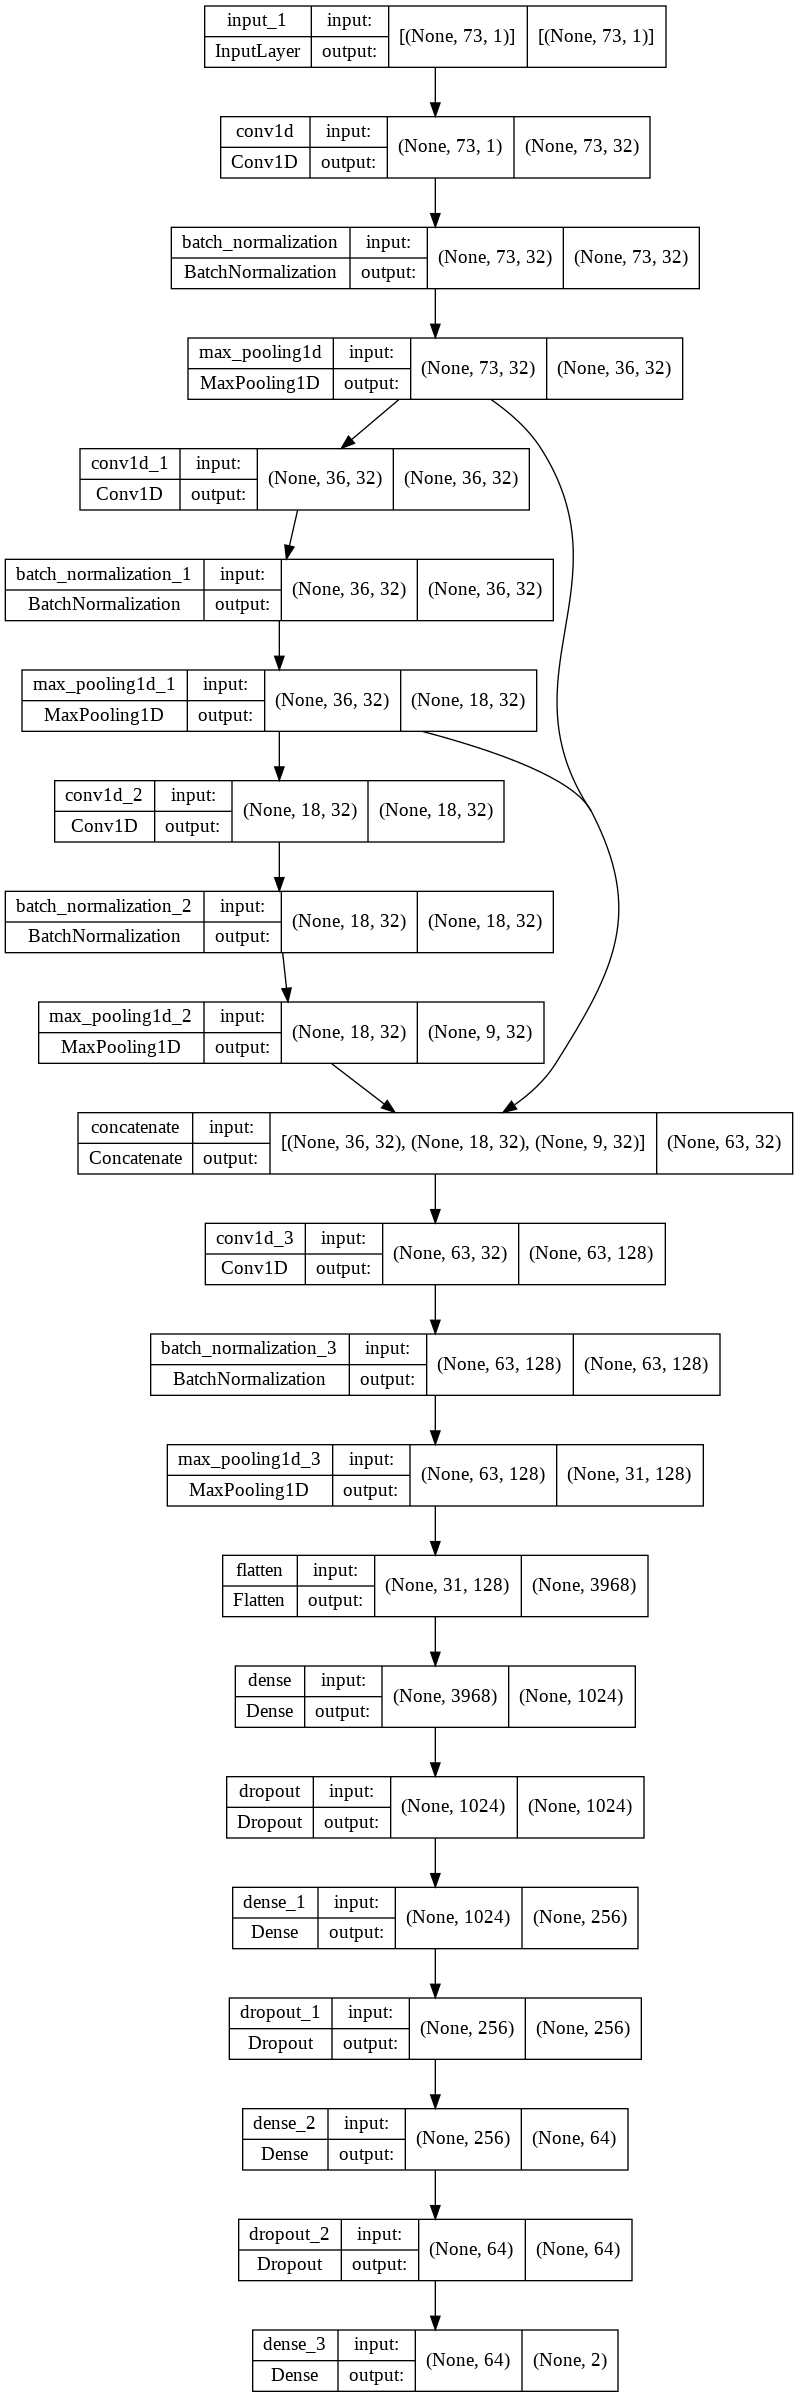

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)


conv1 = Conv1D(32, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

conv3 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

# M1+FFT

**Valence**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_without_FX_Valence_heavy/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_without_FX_Valence_heavy/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for valence on M1+FFT experiment**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.6599
Epoch 1: accuracy improved from -inf to 0.65987, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_without_FX_Valence_heavy/weights-improvement-01-0.6599.hdf5
4685/4685 [==============================] - 55s 9ms/step - loss: 0.6020 - accuracy: 0.6599
Epoch 2/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.7456
Epoch 2: accuracy improved from 0.65987 to 0.74563, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_without_FX_Valence_heavy/weights-improvement-02-0.7456.hdf5
4685/4685 [==============================] - 37s 8ms/step - loss: 0.4940 - accuracy: 0.7456
Epoch 3/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8034
Epoch 3: accuracy improved from 0.74563 to 0.80343, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_without_FX_Vale

**Evaluating the CNN model testing accuracy for valence on M1+FFT experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 15s 3ms/step - loss: 0.1746 - accuracy: 0.9622
Test loss: 0.1745665818452835
Test accuracy: 0.9622310400009155


**Arousal**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_without_FX_Arousal_lite/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_without_FX_Arousal_lite/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Arousal on M1+FFT experiment**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.6889
Epoch 1: accuracy improved from -inf to 0.68890, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_without_FX_Arousal_lite/weights-improvement-01-0.6889.hdf5
4685/4685 [==============================] - 51s 8ms/step - loss: 0.5832 - accuracy: 0.6889
Epoch 2/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7609
Epoch 2: accuracy improved from 0.68890 to 0.76089, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_without_FX_Arousal_lite/weights-improvement-02-0.7609.hdf5
4685/4685 [==============================] - 46s 10ms/step - loss: 0.4802 - accuracy: 0.7609
Epoch 3/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8139
Epoch 3: accuracy improved from 0.76089 to 0.81388, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_without_FX_Arous

**Evaluating the CNN model testing accuracy of Arousal on M1+FFT experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 15s 3ms/step - loss: 0.1451 - accuracy: 0.9627
Test loss: 0.14508387446403503
Test accuracy: 0.962736964225769


# M1+FFT+FE-L

**Valence**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Valence on M1+FFT+FE-L experiment**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.7963
Epoch 1: accuracy improved from -inf to 0.79629, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Like/weights-improvement-01-0.7963.hdf5
4685/4685 [==============================] - 60s 10ms/step - loss: 0.4119 - accuracy: 0.7963 - val_loss: 0.2997 - val_accuracy: 0.8591
Epoch 2/100
4682/4685 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.8819
Epoch 2: accuracy improved from 0.79629 to 0.88197, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Like/weights-improvement-02-0.8820.hdf5
4685/4685 [==============================] - 45s 10ms/step - loss: 0.2624 - accuracy: 0.8820 - val_loss: 0.1988 - val_accuracy: 0.9130
Epoch 3/100
4682/4685 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9194
Epoch 3: accuracy improved from 0.88197 to 0.91941, saving model to /content/drive/Sha

**Evaluating the CNN model testing accuracy of Valence on M1+FFT+FE-L experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 18s 4ms/step - loss: 0.0550 - accuracy: 0.9880
Test loss: 0.05495370179414749
Test accuracy: 0.9879610538482666


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Arousal**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Arousal on M1+FFT+FE-L experiment**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.7771
Epoch 1: accuracy improved from -inf to 0.77712, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Like/weights-improvement-01-0.7771.hdf5
4685/4685 [==============================] - 56s 9ms/step - loss: 0.4484 - accuracy: 0.7771 - val_loss: 0.3317 - val_accuracy: 0.8434
Epoch 2/100
4685/4685 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8605
Epoch 2: accuracy improved from 0.77712 to 0.86045, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Like/weights-improvement-02-0.8605.hdf5
4685/4685 [==============================] - 43s 9ms/step - loss: 0.3035 - accuracy: 0.8605 - val_loss: 0.2332 - val_accuracy: 0.8930
Epoch 3/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9032
Epoch 3: accuracy improved from 0.86045 to 0.90322, saving model to /content/drive/Share

**Evaluating the CNN model testing accuracy of Arousal on M1+FFT+FE-L experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 14s 3ms/step - loss: 0.0793 - accuracy: 0.9860
Test loss: 0.07932871580123901
Test accuracy: 0.9860143661499023


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

# M1+FFT+FE-L-D

**Valence**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Dom_Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Dom_Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for valence on M1+FFT+FE-L-D experiment**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4682/4685 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8864
Epoch 1: accuracy improved from -inf to 0.88646, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Dom_Like/weights-improvement-01-0.8865.hdf5
4685/4685 [==============================] - 55s 11ms/step - loss: 0.2567 - accuracy: 0.8865 - val_loss: 0.1327 - val_accuracy: 0.9466
Epoch 2/100
4685/4685 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9550
Epoch 2: accuracy improved from 0.88646 to 0.95500, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Dom_Like/weights-improvement-02-0.9550.hdf5
4685/4685 [==============================] - 47s 10ms/step - loss: 0.1094 - accuracy: 0.9550 - val_loss: 0.0705 - val_accuracy: 0.9707
Epoch 3/100
4681/4685 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9723
Epoch 3: accuracy improved from 0.95500 to 0.97237, saving model to /content/d

**Evaluating the CNN model testing accuracy of Valence on M1+FFT+FE-L-D experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 16s 3ms/step - loss: 0.0141 - accuracy: 0.9968
Test loss: 0.014087273739278316
Test accuracy: 0.9967853426933289


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FX_FE_Dom_Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Arousal**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Dom_like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Dom_like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Arousal on M1+FFT+FE-L-D experiment**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8467
Epoch 1: accuracy improved from -inf to 0.84670, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Dom_like/weights-improvement-01-0.8467.hdf5
4685/4685 [==============================] - 65s 11ms/step - loss: 0.3290 - accuracy: 0.8467 - val_loss: 0.1786 - val_accuracy: 0.9245
Epoch 2/100
4685/4685 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9384
Epoch 2: accuracy improved from 0.84670 to 0.93839, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Dom_like/weights-improvement-02-0.9384.hdf5
4685/4685 [==============================] - 49s 10ms/step - loss: 0.1484 - accuracy: 0.9384 - val_loss: 0.1057 - val_accuracy: 0.9582
Epoch 3/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9612
Epoch 3: accuracy improved from 0.93839 to 0.96120, saving model to /content/d

**Evaluating the CNN model testing accuracy of Arousal on M1+FFT+FE-L-D experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 16s 3ms/step - loss: 0.0166 - accuracy: 0.9953
Test loss: 0.0166315920650959
Test accuracy: 0.9952612519264221


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FX_FE_Dom_like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

# M1+FFT+FE-3

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Valence**

**Fit the model for valence on M1+FFT+FE-3 Experiment**


In [ ]:

H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9131
Epoch 1: accuracy improved from -inf to 0.91308, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-01-0.9131.hdf5
4685/4685 [==============================] - 62s 11ms/step - loss: 0.2008 - accuracy: 0.9131
Epoch 2/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9773
Epoch 2: accuracy improved from 0.91308 to 0.97731, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-02-0.9773.hdf5
4685/4685 [==============================] - 47s 10ms/step - loss: 0.0602 - accuracy: 0.9773
Epoch 3/100
4682/4685 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9867
Epoch 3: accuracy improved from 0.97731 to 0.98670, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epo

**Evaluating the CNN model testing accuracy valence on M1+FFT+FE-3 experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 14s 3ms/step - loss: 0.0039 - accuracy: 0.9989
Test loss: 0.0038879108615219593
Test accuracy: 0.9989113807678223


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/M1_valence_FFT_FE_100epochs_history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Arousal**

**Fit the model for arousal on M1+FFT+FE-3 Experiment**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8584
Epoch 1: accuracy improved from -inf to 0.85843, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FFT_FE_100epochs_Arousal/weights-improvement-01-0.8584.hdf5
4685/4685 [==============================] - 53s 8ms/step - loss: 0.3044 - accuracy: 0.8584
Epoch 2/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9521
Epoch 2: accuracy improved from 0.85843 to 0.95214, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FFT_FE_100epochs_Arousal/weights-improvement-02-0.9521.hdf5
4685/4685 [==============================] - 37s 8ms/step - loss: 0.1185 - accuracy: 0.9521
Epoch 3/100
4680/4685 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9739
Epoch 3: accuracy improved from 0.95214 to 0.97390, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FFT_FE_100epoch

**Evaluating the CNN model testing accuracy of arousal on M1+FFT+FE-3 experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 15s 3ms/step - loss: 0.0074 - accuracy: 0.9983
Test loss: 0.007445973344147205
Test accuracy: 0.9983158111572266


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FFT_FE_100epochs_Arousal/M1_arousal_FFT_FE_100epochs_history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

# M2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 16)       112         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 35, 16)       0           ['batch_normalization[0][0]']

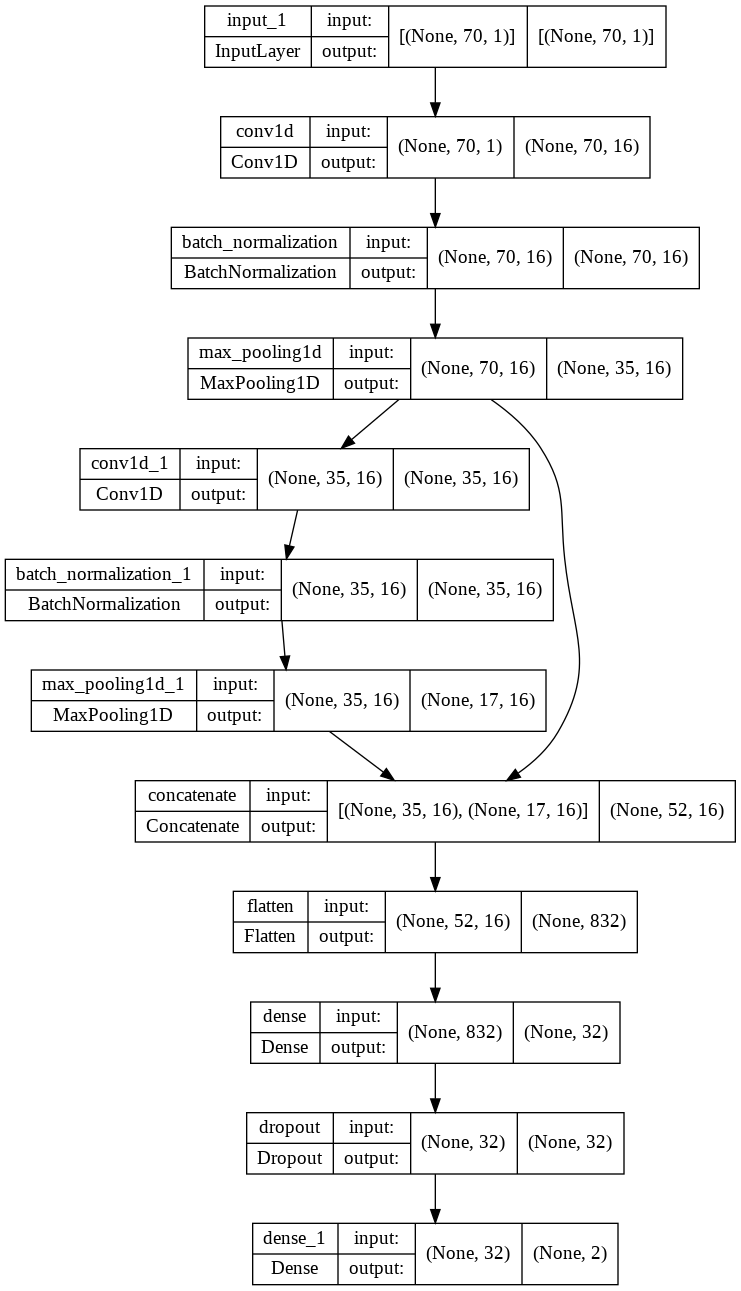

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(16, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(16,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)


connect1 = concatenate([pool1, pool2], axis=1)


flat = Flatten() (connect1)




dense3 = Dense(32, activation='relu') (flat)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

# M2+FFT

**Valence**

**Loading the saved weights of CNN model for Valence on M2+FFT experiment**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M2_without_FX_Valence_lite/weights-improvement-97-0.7636.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 23s 3ms/step - loss: 0.4102 - accuracy: 0.7868
Test loss: 0.4102260172367096
Test accuracy: 0.78681480884552


**Arousal**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2_without_FX_Arousal_lite/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2_without_FX_Arousal_lite/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Arousal on M2+FFT experiment**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.6717
Epoch 1: accuracy improved from -inf to 0.67173, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2_without_FX_Arousal_lite/weights-improvement-01-0.6717.hdf5
4685/4685 [==============================] - 45s 7ms/step - loss: 0.5972 - accuracy: 0.6717
Epoch 2/100
4681/4685 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.6992
Epoch 2: accuracy improved from 0.67173 to 0.69916, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2_without_FX_Arousal_lite/weights-improvement-02-0.6992.hdf5
4685/4685 [==============================] - 24s 5ms/step - loss: 0.5593 - accuracy: 0.6992
Epoch 3/100
4680/4685 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.7115
Epoch 3: accuracy improved from 0.69916 to 0.71152, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2_without_FX_Arousa

**Evaluating the CNN model testing accuracy for Arousal on M2+FFT experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 12s 2ms/step - loss: 0.3932 - accuracy: 0.8022
Test loss: 0.39316633343696594
Test accuracy: 0.8022156953811646


# M2+FFT+FE-L

**Valence**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Valence on M2+FFT+FE-L experiment and got final validation accuracy of 0.9127**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.7687
Epoch 1: accuracy improved from -inf to 0.76872, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Like/weights-improvement-01-0.7687.hdf5
4685/4685 [==============================] - 25s 5ms/step - loss: 0.4558 - accuracy: 0.7687 - val_loss: 0.4021 - val_accuracy: 0.7996
Epoch 2/100
4680/4685 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.7980
Epoch 2: accuracy improved from 0.76872 to 0.79798, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Like/weights-improvement-02-0.7980.hdf5
4685/4685 [==============================] - 23s 5ms/step - loss: 0.3960 - accuracy: 0.7980 - val_loss: 0.3554 - val_accuracy: 0.8202
Epoch 3/100
4674/4685 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8109
Epoch 3: accuracy improved from 0.79798 to 0.81097, sa

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Arousal**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Valence on M2+FFT+FE-L experiment and got final validation accuracy of 0.8942**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.4987 - accuracy: 0.7446
Epoch 1: accuracy improved from -inf to 0.74462, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Like/weights-improvement-01-0.7446.hdf5
4685/4685 [==============================] - 24s 5ms/step - loss: 0.4987 - accuracy: 0.7446 - val_loss: 0.4295 - val_accuracy: 0.7880
Epoch 2/100
4676/4685 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.7809
Epoch 2: accuracy improved from 0.74462 to 0.78088, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Like/weights-improvement-02-0.7809.hdf5
4685/4685 [==============================] - 24s 5ms/step - loss: 0.4350 - accuracy: 0.7809 - val_loss: 0.4014 - val_accuracy: 0.8040
Epoch 3/100
4676/4685 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.7942
Epoch 3: accuracy improved from 0.7808

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

# M2+FFT+FE-L-D

**Valence**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Dominance-Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Dominance-Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for valence on M2+FFT+FE-L-D experiment and got final validation accuracy of 0.9783**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8455
Epoch 1: accuracy improved from -inf to 0.84551, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Dominance-Like/weights-improvement-01-0.8455.hdf5
4685/4685 [==============================] - 39s 6ms/step - loss: 0.3335 - accuracy: 0.8455 - val_loss: 0.2460 - val_accuracy: 0.8887
Epoch 2/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.8838
Epoch 2: accuracy improved from 0.84551 to 0.88382, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Dominance-Like/weights-improvement-02-0.8838.hdf5
4685/4685 [==============================] - 28s 6ms/step - loss: 0.2456 - accuracy: 0.8838 - val_loss: 0.1983 - val_accuracy: 0.9060
Epoch 3/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.8983
Epoch 3: accuracy improved from 0.

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-Dominance-Like/history_epoch_100_decrease_4_layer', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Arousal**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Dominance-Like/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Dominance-Like/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for arousal on M2+FFT+FE-L-D experiment and got final validation accuracy of 0.9600**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/100
4675/4685 [============================>.] - ETA: 0s - loss: 0.4182 - accuracy: 0.7965
Epoch 1: accuracy improved from -inf to 0.79659, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Dominance-Like/weights-improvement-01-0.7966.hdf5
4685/4685 [==============================] - 27s 6ms/step - loss: 0.4180 - accuracy: 0.7966 - val_loss: 0.3204 - val_accuracy: 0.8496
Epoch 2/100
4679/4685 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8470
Epoch 2: accuracy improved from 0.79659 to 0.84699, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Dominance-Like/weights-improvement-02-0.8470.hdf5
4685/4685 [==============================] - 26s 5ms/step - loss: 0.3205 - accuracy: 0.8470 - val_loss: 0.2616 - val_accuracy: 0.8778
Epoch 3/100
4675/4685 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8641
Epoch 3: accuracy 

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-Arousal-FX-Dominance-Like/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

# M2+FFT+FE-3

**Valence**

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model for Valence on M2+FFT+FE-3 experiment**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4678/4685 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8624
Epoch 1: accuracy improved from -inf to 0.86245, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-01-0.8625.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.2999 - accuracy: 0.8625
Epoch 2/100
4679/4685 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9117
Epoch 2: accuracy improved from 0.86245 to 0.91169, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-02-0.9117.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.1875 - accuracy: 0.9117
Epoch 3/100
4681/4685 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9275
Epoch 3: accuracy improved from 0.91169 to 0.92754, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d

**Evaluating the CNN model testing accuracy for Valence on M2+FFT+FE-3 experiment**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 11s 2ms/step - loss: 0.0206 - accuracy: 0.9923
Test loss: 0.02064960077404976
Test accuracy: 0.9922963380813599


**Figure 9. M2 model train vs. validation accuracy graph on valence class.**

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/TSR-M2-FX-3/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

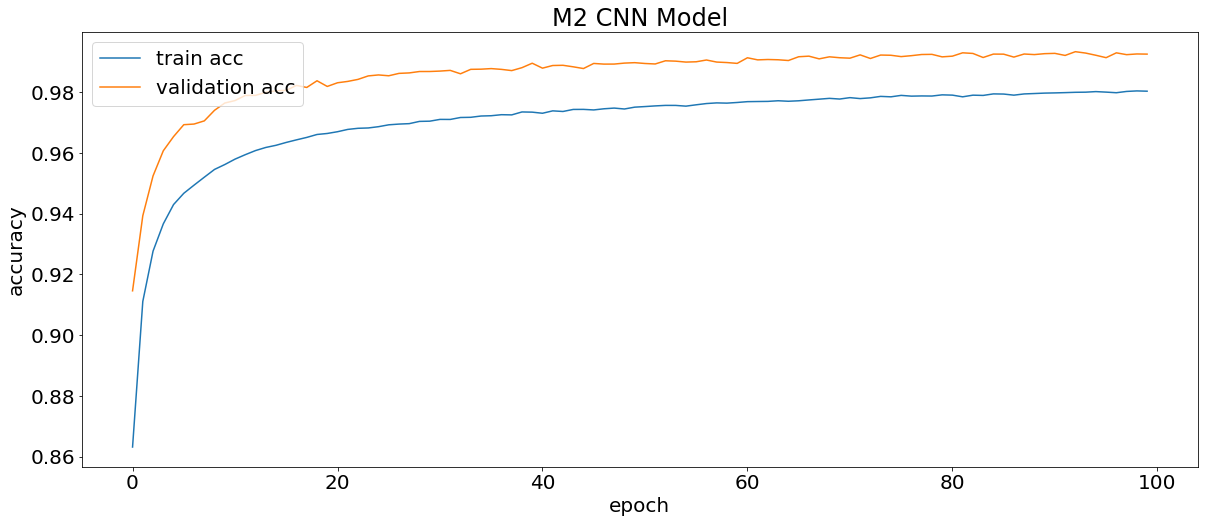

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["font.size"] = 20

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('M2 CNN Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'validation acc'], loc='upper left')
plt.savefig('/content/drive/Shareddrives/DEAP EEG/MDPI Sensor Journal/Paper figure/M2 100 epoch train and test accuracy curve.png', dpi=300)

**Arousal**

**Loading the saved weights of CNN model for Arousal on M2+FX+FE-3 experiment**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2+FX_100_Epoch/weights-improvement-99-0.9563.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 22s 3ms/step - loss: 0.0533 - accuracy: 0.9798
Test loss: 0.053267702460289
Test accuracy: 0.9797643423080444


# Generate Confusion Matrix and Classification Report on M1 & M2 Model for Valence and Arousal

**M2+FFT+FE-3 Valence**

**Loading the saved weights of CNN model M2+FFT+FE-3 Valence**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-96-0.9805.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 21s 3ms/step - loss: 0.0191 - accuracy: 0.9930
Test loss: 0.019071297720074654
Test accuracy: 0.9929879903793335


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

4880/4880 [==============================] - 9s 2ms/step


**Classification report of CNN model for M2+FFT+FE-3 Valence**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67832
           1       1.00      0.99      0.99     88328

   micro avg       0.99      0.99      0.99    156160
   macro avg       0.99      0.99      0.99    156160
weighted avg       0.99      0.99      0.99    156160
 samples avg       0.99      0.99      0.99    156160



**Confusion Matrix for M2+FFT+FE-3 Valence**

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=45,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[67558   274]
 [  821 87507]]
Normalized confusion matrix
[[1.   0.  ]
 [0.01 0.99]]


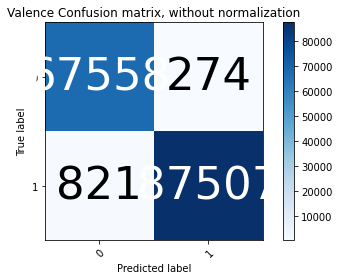

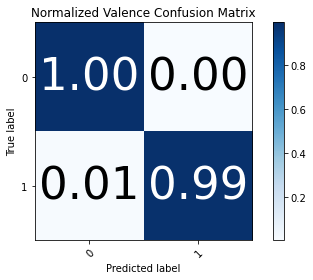

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_loaded.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Valence Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Valence Confusion Matrix')
plt.savefig('Normalized Valence Confusion Matrix for 2 class on M2 Model.png',bbox_inches='tight',dpi=300)

plt.show()

**M2+FFT+FE-3 Arousal**

**Loading the saved weights of CNN model M2+FFT+FE-3 Arousal**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M2+FX_100_Epoch/weights-improvement-99-0.9563.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 15s 3ms/step - loss: 0.0533 - accuracy: 0.9798
Test loss: 0.053267702460289
Test accuracy: 0.9797643423080444


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

4880/4880 [==============================] - 10s 2ms/step


**Classification report of CNN model for M2+FFT+FE-3 Arousal**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     64172
           1       0.98      0.99      0.98     91988

   micro avg       0.98      0.98      0.98    156160
   macro avg       0.98      0.98      0.98    156160
weighted avg       0.98      0.98      0.98    156160
 samples avg       0.98      0.98      0.98    156160



**Confusion Matrix for M2+FFT+FE-3 Arousal**

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=45,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[67558   274]
 [  821 87507]]
Normalized confusion matrix
[[1.   0.  ]
 [0.01 0.99]]


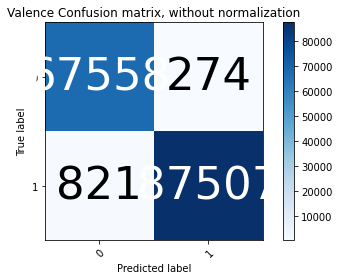

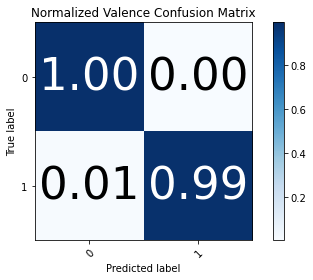

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_loaded.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Valence Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Valence Confusion Matrix')
plt.savefig('Normalized Valence Confusion Matrix for 2 class on M2 Model.png',bbox_inches='tight',dpi=300)

plt.show()

**M1+FFT+FE-3 Valence**

**Loading the saved weights of CNN model M1+FFT+FE-3 Valence**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-63-0.9986.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 20s 4ms/step - loss: 0.0028 - accuracy: 0.9992
Test loss: 0.00277495919726789
Test accuracy: 0.9991995096206665


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

4880/4880 [==============================] - 12s 2ms/step


**Classification report of CNN model for M1+FFT+FE-3 Valence**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67832
           1       1.00      1.00      1.00     88328

   micro avg       1.00      1.00      1.00    156160
   macro avg       1.00      1.00      1.00    156160
weighted avg       1.00      1.00      1.00    156160
 samples avg       1.00      1.00      1.00    156160



**Confusion Matrix for M1+FFT+FE-3 Valence**

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=45,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

4880/4880 [==============================] - 12s 2ms/step
Confusion matrix, without normalization
[[67771    61]
 [   64 88264]]
Normalized confusion matrix
[[9.99e-01 8.99e-04]
 [7.25e-04 9.99e-01]]


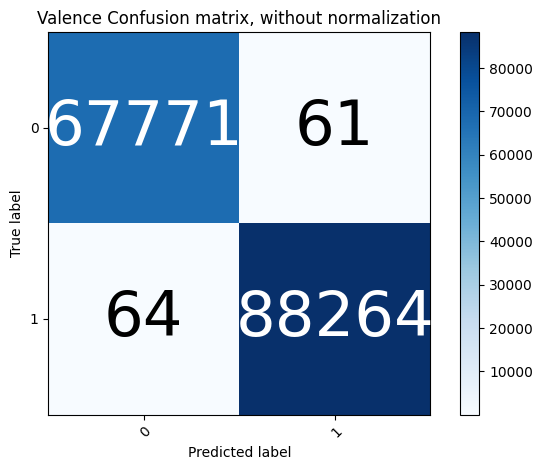

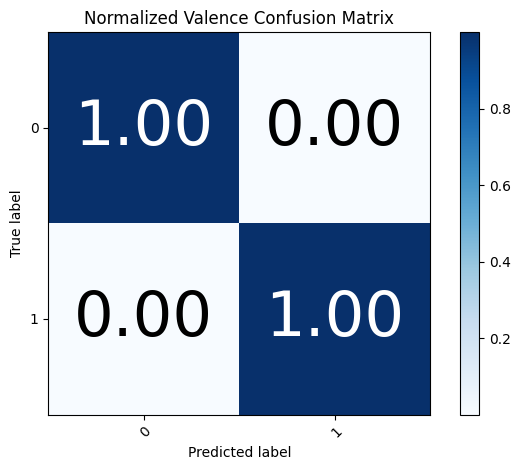

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_loaded.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Valence Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Valence Confusion Matrix')
plt.savefig('Normalized Valence Confusion Matrix for 2 class on M2 Model.png',bbox_inches='tight',dpi=300)

plt.show()

**M1+FFT+FE-3 Arousal**

**Loading the saved weights of CNN model M1+FFT+FE-3 Arousal**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Arousal/M1_FFT_FE_100epochs_Arousal/weights-improvement-52-0.9980.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 16s 3ms/step - loss: 0.0071 - accuracy: 0.9986
Test loss: 0.007114801090210676
Test accuracy: 0.9985655546188354


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

4880/4880 [==============================] - 13s 3ms/step


**Classification report of CNN model for M1+FFT+FE-3 Arousal**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64172
           1       1.00      1.00      1.00     91988

   micro avg       1.00      1.00      1.00    156160
   macro avg       1.00      1.00      1.00    156160
weighted avg       1.00      1.00      1.00    156160
 samples avg       1.00      1.00      1.00    156160



**Confusion Matrix for M1+FFT+FE-3 Arousal**

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=45,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

4880/4880 [==============================] - 13s 3ms/step
Confusion matrix, without normalization
[[64046   126]
 [   98 91890]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


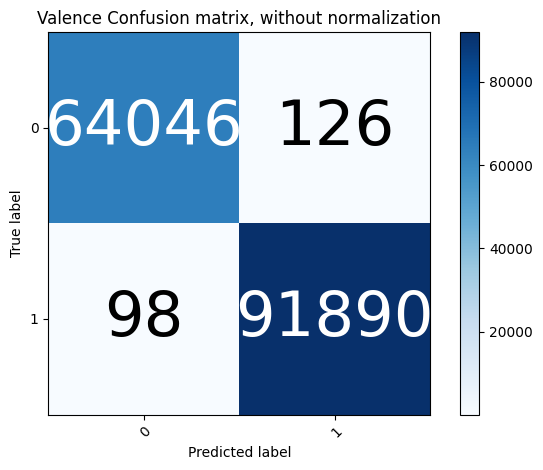

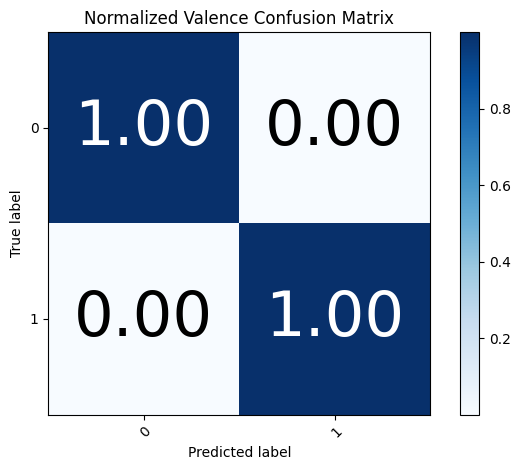

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_loaded.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Valence Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Valence Confusion Matrix')
plt.savefig('Normalized Valence Confusion Matrix for 2 class on M2 Model.png',bbox_inches='tight',dpi=300)

plt.show()